# Importing Libraries

In [1]:
import os
import random
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import math
import imageio
from IPython.display import Image as IPImage

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
import torchvision

import kagglehub


# Loading the dataset

In [2]:
import kagglehub

path = kagglehub.dataset_download("ly9802/stanfordcars")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stanfordcars


# Hyperparameter and Setup

In [3]:
# Hyperparameters etc
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3
EPOCHS = 5
ROOT_DIR = path
NUM_WORKERS = 2
T = 300

cuda


# Custom Dataset

In [4]:
class CarDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

        csv_file = os.path.join(root_dir, f'{split}.csv')
        self.data = pd.read_csv(csv_file)

        self.image_paths = self.data['filename'].values
        self.labels = self.data['label'].values

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir+"/data/",self.image_paths[idx])
        image = Image.open(img_path).convert('RGB')
        label = float(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        return image, label

# EDA

Image 0 shape: torch.Size([3, 183, 276])
Image 1 shape: torch.Size([3, 938, 1500])
Image 2 shape: torch.Size([3, 480, 640])
Image 3 shape: torch.Size([3, 1096, 650])
Image 4 shape: torch.Size([3, 768, 1024])
Image 5 shape: torch.Size([3, 266, 400])
Image 6 shape: torch.Size([3, 853, 1280])
Image 7 shape: torch.Size([3, 184, 275])
Image 8 shape: torch.Size([3, 332, 500])
Image 9 shape: torch.Size([3, 457, 900])


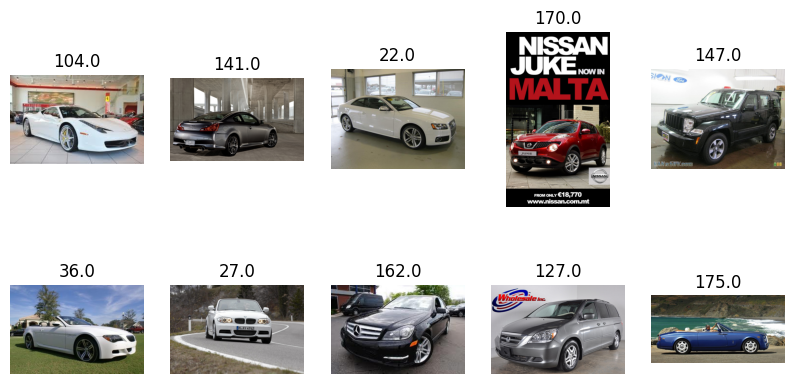

In [5]:
transform = transforms.Compose({
    transforms.ToTensor()
})
dataset = CarDataset(ROOT_DIR, transform= transform)
dataloader = DataLoader(dataset, shuffle = True, batch_size = 1, num_workers = NUM_WORKERS)

data_iter = iter(dataloader)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    image, label = next(data_iter)
    image = image[0]
    label = label[0]
    print(f"Image {i} shape: {image.shape}")
    img_np = np.transpose(image.numpy(), (1, 2, 0))
    ax.imshow(img_np)
    ax.set_title(f"{label}")
    ax.axis("off")
plt.show()


130


/tmp/ipython-input-6-3802917290.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='deep')


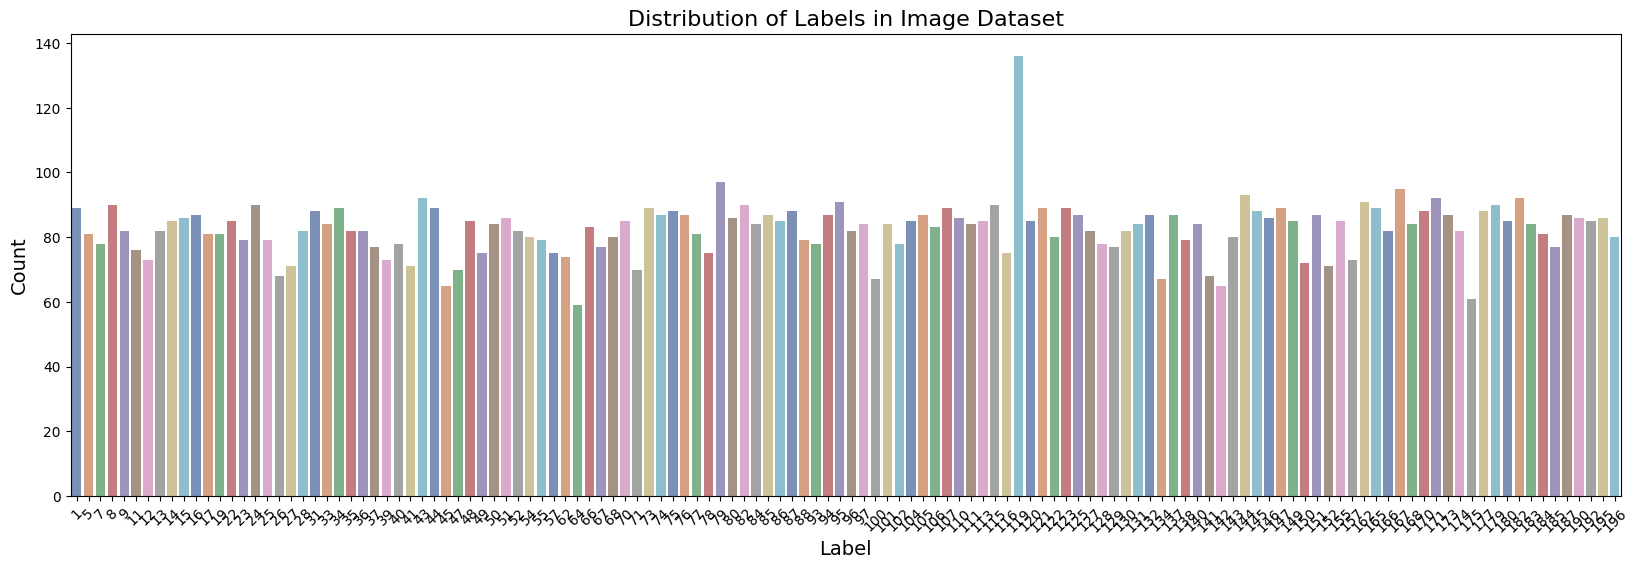

In [6]:
df = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
label_counts = df['label'].value_counts()
print(len(label_counts))

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='deep')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
all_labels = [label for _, label in dataset]
unique_labels = sorted(set(all_labels))

dataset = CarDataset(root_dir= ROOT_DIR, transform=train_transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
print(f"Total number of images loaded: {len(dataset)}")
print(f"Unique labels ({len(unique_labels)} total): {unique_labels}")
images, label = next(iter(dataloader))
print("Shape of one image tensor:", images[0].shape)
print("Shape of a group of iamges is:", images.shape)

Total number of images loaded: 10744
Unique labels (130 total): [1.0, 5.0, 7.0, 8.0, 9.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 19.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 31.0, 33.0, 34.0, 35.0, 36.0, 37.0, 39.0, 40.0, 41.0, 43.0, 44.0, 45.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 54.0, 55.0, 57.0, 62.0, 64.0, 66.0, 67.0, 68.0, 70.0, 71.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 82.0, 84.0, 85.0, 86.0, 87.0, 88.0, 93.0, 94.0, 95.0, 96.0, 97.0, 100.0, 101.0, 102.0, 104.0, 105.0, 106.0, 107.0, 110.0, 111.0, 113.0, 115.0, 116.0, 119.0, 120.0, 121.0, 122.0, 123.0, 125.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 134.0, 137.0, 138.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 149.0, 150.0, 151.0, 152.0, 155.0, 157.0, 162.0, 165.0, 166.0, 167.0, 168.0, 170.0, 171.0, 173.0, 174.0, 175.0, 177.0, 179.0, 180.0, 182.0, 183.0, 184.0, 185.0, 187.0, 190.0, 192.0, 195.0, 196.0]
Shape of one image tensor: torch.Size([3, 64, 64])
Shape of a group of iamges is: torch.Size([32,

# Forward Diffusion Process

$$
\beta_t = \text{start} + \frac{t}{T} \times (\text{end} - \text{start})
$$


In [8]:
def linear_beta_schedule(timesteps, start = 0.0001, end = 0.02):
    return torch.linspace(start, end, timesteps)

In [9]:
def get_index_from_list(values, timesteps, x_shape):
    """
    Extracts the appropriate index for each timestep and reshapes it to broadcast over the image.
    """
    # Move values to the same device as timesteps
    values = values.to(timesteps.device)
    batch_size = timesteps.shape[0]
    out = values.gather(0, timesteps)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))


The forward diffusion process is given by:

$$
x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon
$$

Where:

- $ x_0 $ is the original image.
- $ x_t $ is the noisy image at time $ t $.
- $ \bar{\alpha}_t $ is the cumulative product of the noise schedule up to time $ t $.
- $ \epsilon \sim \mathcal{N}(0, I) $ is Gaussian noise.


In [10]:
def forward(x_0, t, device = "cpu"):
    """
    take an image and a timesteps
    return the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)

    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    return (
        sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device),
        noise.to(device)
    )


$\beta_t \in [\beta_1, \beta_2, \dots, \beta_T]$


In [11]:
betas = linear_beta_schedule(timesteps=T)

$\alpha_t = 1 - \beta_t$


In [12]:
alphas = 1. - betas

$\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$


In [13]:
alphas_cumprod = torch.cumprod(alphas, axis=0)

$\bar{\alpha}_{t-1}, \quad \text{with } \bar{\alpha}_0 = 1$


In [14]:
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

$\sqrt{\frac{1}{\alpha_t}}$


In [15]:
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

$\sqrt{\bar{\alpha}_t}$


In [16]:
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)

$\sqrt{1 - \bar{\alpha}_t}$


In [17]:
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

$\tilde{\beta}_t = \frac{(1 - \bar{\alpha}_{t-1}) \cdot \beta_t}{1 - \bar{\alpha}_t}$


In [18]:
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

#  Visualizing the Forward Diffusion Process

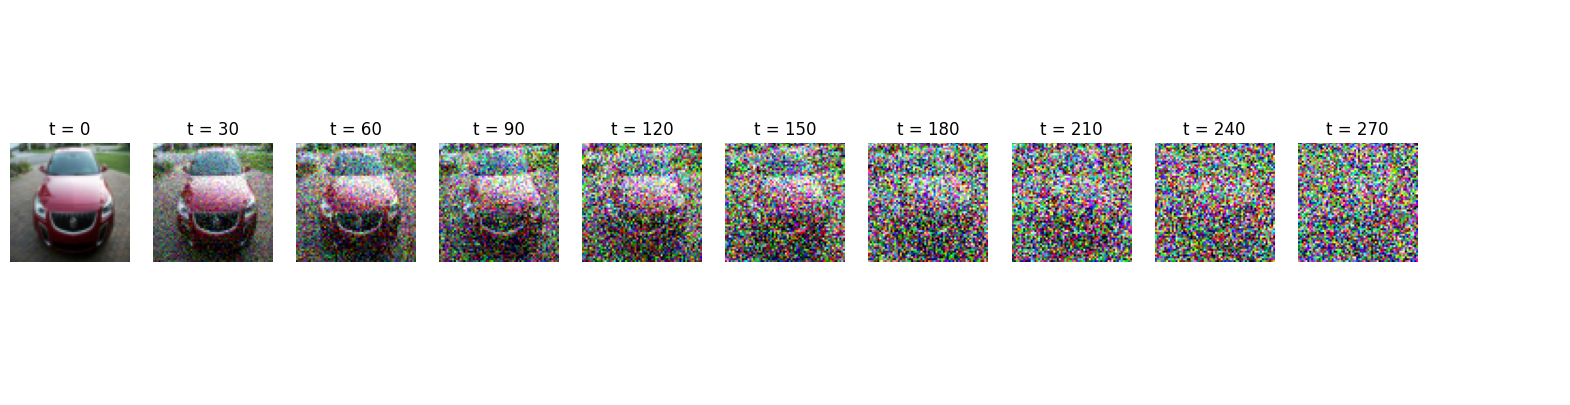

In [19]:
image = next(iter(dataloader))[0]
image = image[0]

num_images = 10
stepsize = int(T / num_images)

plt.figure(figsize=(20, 5))
plt.axis("off")

for i, idx in enumerate(range(0, T, stepsize)):
    t = torch.tensor([idx], dtype=torch.int64)
    noised_image, noise = forward(image, t)
    img = noised_image.numpy()
    img = np.transpose(img, (1, 2, 0))  # (C, H, W) -> (H, W, C)
    img_display = (img + 1) / 2
    ax = plt.subplot(1, num_images + 1, i + 1)
    ax.imshow(img_display)
    ax.set_title(f"t = {idx}")
    ax.axis("off")

plt.show()

# Creating the Model

In [20]:
class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, time):
        device = time.device
        half_dim = self.embedding_dim // 2
        scale = math.log(10000) / (half_dim - 1)
        freq = torch.exp(torch.arange(half_dim, device=device) * -scale)
        angles = time[:, None] * freq[None, :]
        return torch.cat([angles.sin(), angles.cos()], dim=-1)

In [21]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, upsample=False):
        super().__init__()
        self.time_fc = nn.Linear(time_dim, out_channels)

        if upsample:
            self.initial_conv = nn.Conv2d(in_channels * 2, out_channels, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
        else:
            self.initial_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)

        self.second_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x, t):
        h = self.activation(self.norm1(self.initial_conv(x)))
        time_emb = self.activation(self.time_fc(t))[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.activation(self.norm2(self.second_conv(h)))
        return self.transform(h)

In [22]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        input_channels = 3
        output_channels = 3
        base_channels = [64, 128, 256, 512, 1024]
        reverse_channels = list(reversed(base_channels))
        time_embedding_dim = 32

        # Time embedding MLP
        self.time_embedding = nn.Sequential(
            TimeEmbedding(time_embedding_dim),
            nn.Linear(time_embedding_dim, time_embedding_dim),
            nn.ReLU()
        )

        # Initial projection
        self.init_conv = nn.Conv2d(input_channels, base_channels[0], kernel_size=3, padding=1)

        # Downsampling path
        self.down_blocks = nn.ModuleList([
            ConvBlock(base_channels[i], base_channels[i + 1], time_embedding_dim)
            for i in range(len(base_channels) - 1)
        ])

        # Upsampling path
        self.up_blocks = nn.ModuleList([
            ConvBlock(reverse_channels[i], reverse_channels[i + 1], time_embedding_dim, upsample=True)
            for i in range(len(reverse_channels) - 1)
        ])

        # Final projection
        self.final_conv = nn.Conv2d(base_channels[0], output_channels, kernel_size=1)

    def forward(self, x, time):
        time_embed = self.time_embedding(time)
        x = self.init_conv(x)

        skip_connections = []
        for block in self.down_blocks:
            x = block(x, time_embed)
            skip_connections.append(x)

        for block in self.up_blocks:
            skip_x = skip_connections.pop()
            x = torch.cat((x, skip_x), dim=1)
            x = block(x, time_embed)

        return self.final_conv(x)


# Instantiate and inspect
model = SimpleUNet()
print("Parameter count:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Parameter count: 62438883


# Training

In [23]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [24]:
def show_image(image):
    if image.ndim == 4:
        image = image[0]
    image = (image + 1) / 2
    image = torch.clamp(image, 0, 1)
    image_np = image.permute(1, 2, 0).numpy()
    plt.imshow(image_np)
    plt.axis("off")

In [25]:
@torch.no_grad()
def denoise_one_step(current_image, timestep):
    """
    Performs a single reverse diffusion step (denoising) at a given timestep.
    """
    beta_t = get_index_from_list(betas, timestep, current_image.shape)
    sqrt_one_minus_alpha_bar_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, timestep, current_image.shape)
    sqrt_recip_alpha_t = get_index_from_list(sqrt_recip_alphas, timestep, current_image.shape)

    predicted_noise = model(current_image, timestep)

    model_mean = sqrt_recip_alpha_t * (
        current_image - beta_t * predicted_noise / sqrt_one_minus_alpha_bar_t
    )

    posterior_var_t = get_index_from_list(posterior_variance, timestep, current_image.shape)

    if timestep == 0:
        return model_mean
    else:
        random_noise = torch.randn_like(current_image)
        return model_mean + torch.sqrt(posterior_var_t) * random_noise


In [26]:
# @torch.no_grad()
# def generate_and_plot_sample():
#     """
#     Generates an image by reversing the diffusion process from pure noise.
#     Plots intermediate
#     """
#     image_size = IMAGE_SIZE
#     image = torch.randn((1, 3, image_size, image_size), device=device)

#     plt.figure(figsize=(15, 15))
#     plt.axis('off')

#     num_plots = 10
#     interval = int(T / num_plots)

#     for timestep in reversed(range(T)):
#         t_tensor = torch.full((1,), timestep, device=device, dtype=torch.long)
#         image = denoise_one_step(image, t_tensor)
#         image = torch.clamp(image, -1.0, 1.0)
#         if timestep % interval == 0:
#             plt.subplot(1, num_plots, int(timestep / interval) + 1)
#             show_image(image.detach().cpu())
#     plt.show()

@torch.no_grad()
def generate_and_plot_sample_with_gif(epoch, save_dir="gif_frames"):
    """
    Generates a denoised image from noise and plots intermediate steps.
    Saves the entire figure as a frame for a GIF.
    """
    os.makedirs(save_dir, exist_ok=True)

    image_size = IMAGE_SIZE
    image = torch.randn((1, 3, image_size, image_size), device=device)

    num_plots = 10
    interval = int(T / num_plots)

    plt.figure(figsize=(20, 4))
    plt.axis("off")

    for i, timestep in enumerate(reversed(range(T))):
        t_tensor = torch.full((1,), timestep, device=device, dtype=torch.long)
        image = denoise_one_step(image, t_tensor)
        image = torch.clamp(image, -1.0, 1.0)

        if timestep % interval == 0:
            plt.subplot(1, num_plots, int(timestep / interval) + 1)
            show_image(image.detach().cpu())
            plt.axis("off")
            plt.title(f"t={timestep}")

    plt.tight_layout()
    plt.savefig(f"{save_dir}/epoch_{epoch:03d}.png")
    plt.close()


In [27]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
losses = []

for epoch in range(EPOCHS):
    epoch_losses = []
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        images = batch[0].to(device)
        batch_size = images.shape[0]
        timesteps = torch.randint(0, T, (batch_size,), device=device)

        loss = get_loss(model, images, timesteps)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item():.4f}")

    generate_and_plot_sample_with_gif(epoch)
    average_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(average_loss)


Epoch 0 | Step 335 | Loss: 0.2924


# Result

In [28]:
def create_training_gif(save_dir="gif_frames", gif_path="training_progress.gif", fps=5):
    frame_paths = sorted(glob(f"{save_dir}/epoch_*.png"))
    frames = [imageio.imread(frame) for frame in frame_paths]
    imageio.mimsave(gif_path, frames, fps=fps)

def show_training_gif(gif_path="training_progress.gif"):
    return IPImage(filename=gif_path)


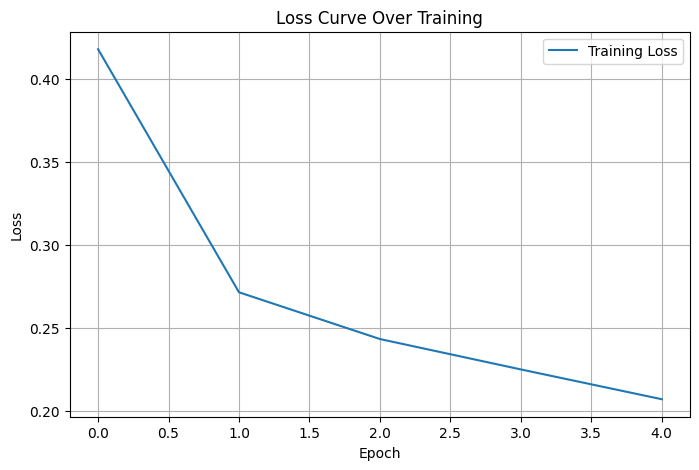

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve Over Training")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-28-2554173468.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(frame) for frame in frame_paths]


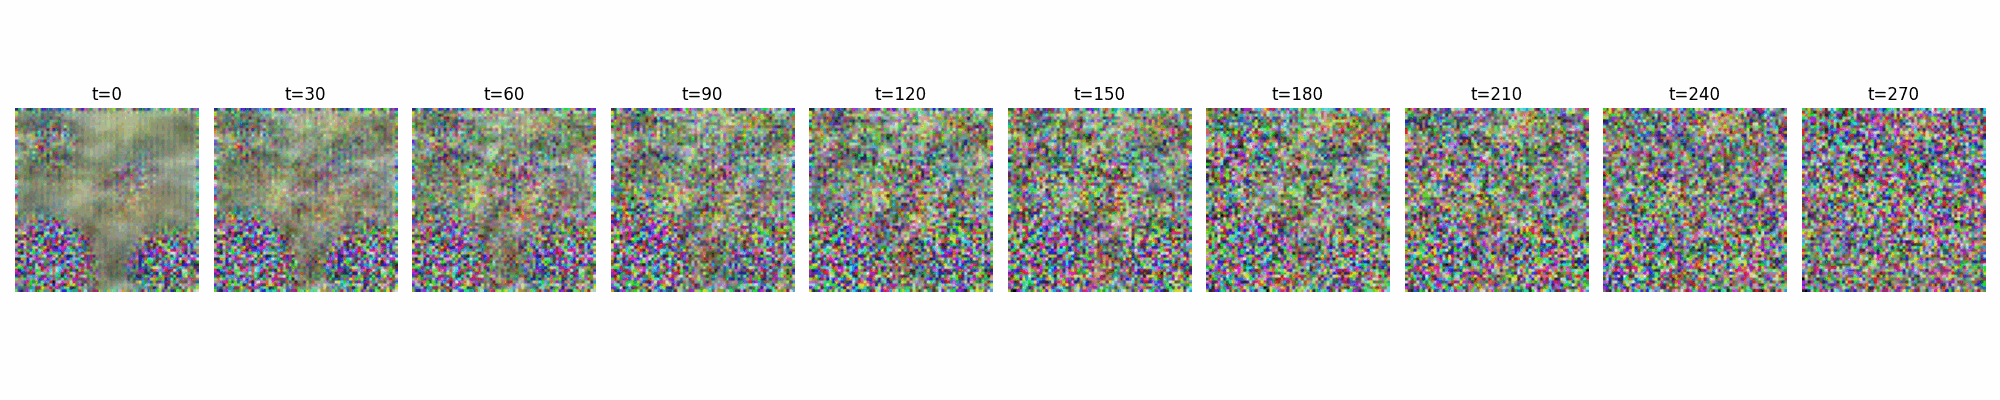

In [30]:
create_training_gif()
show_training_gif()
